# 📄 Hoja de Trabajo 2
Integrantes
- Diego Alexander Hernández Silvestre - 21270
- Mario Antonio Guerra Morales - 21008
- Linda Inés Jiménez Vides 21169

## 💻 Ejercicio 1
### Preparación del conjunto de datos 📈

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar el conjunto de datos de Iris
iris = load_iris()
X = iris.data  # Características
y = iris.target  # Etiquetas

df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Dividir el conjunto de datos en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Mostrar los tamaños de los conjuntos resultantes
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de validación: {X_test.shape[0]} muestras")
df_iris.head()


Conjunto de entrenamiento: 105 muestras
Conjunto de validación: 45 muestras


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### 🧠 Arquitectura del modelo

In [3]:
# Red neuronal feedforward
class SimpleFeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleFeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  # Capa de entrada
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # Capa oculta
        self.fc3 = nn.Linear(hidden_size2, output_size)  # Capa de salida

        self.relu = nn.ReLU()  # Función de activación ReLU
        self.softmax = nn.Softmax(dim=1)  # Función de activación Softmax para la capa de salida

    def forward(self, x):
        # Pasar los datos a través de la red
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Parámetros de la red
input_size = 4  # Número de características de entrada
hidden_size1 = 10  # Número de neuronas en la primera capa oculta
hidden_size2 = 8  # Número de neuronas en la segunda capa oculta
output_size = 3  # Número de clases de salida

# Instancia de la red neuronal
model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)

# Mostrar la estructura de la red
print(model)


SimpleFeedforwardNN(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


### 📉 Funciones de perdida

In [4]:
# Verificar si CUDA está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Crear DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
def loss_functions():
    # Definir las funciones de pérdida a comparar
    loss_functions = [
        ('CrossEntropy', nn.CrossEntropyLoss()),
        ('MSE', nn.MSELoss()),
        ('NLL', nn.NLLLoss())
    ]

    results = []

    # Iterar sobre cada función de pérdida
    for loss_name, criterion in loss_functions:
        # Inicializar el modelo y el optimizador
        model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        train_losses = []
        test_losses = []

        # Entrenamiento durante 100 épocas
        for epoch in range(100):
            model.train()  # Poner el modelo en modo entrenamiento
            outputs = model(X_train_tensor.to(device))  # Hacer una pasada hacia adelante

            # Calcular la pérdida según la función de pérdida
            if loss_name == 'CrossEntropy':
                loss = criterion(outputs, y_train_tensor.to(device))
            elif loss_name == 'NLL':
                log_probs = nn.functional.log_softmax(outputs, dim=1)
                loss = criterion(log_probs, y_train_tensor.to(device))
            else:
                # 'MSE' usa etiquetas one-hot
                loss = criterion(outputs, nn.functional.one_hot(y_train_tensor, num_classes=output_size).float().to(device))

            # Actualizar los gradientes
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            # Evaluar el modelo
            model.eval()  # Poner el modelo en modo evaluación
            with torch.no_grad():
                test_outputs = model(X_test_tensor.to(device))  # Hacer una pasada hacia adelante en el conjunto de prueba

                # Calcular la pérdida en el conjunto de prueba
                if loss_name == 'CrossEntropy':
                    test_loss = criterion(test_outputs, y_test_tensor.to(device))
                elif loss_name == 'NLL':
                    log_probs = nn.functional.log_softmax(test_outputs, dim=1)
                    test_loss = criterion(log_probs, y_test_tensor.to(device))
                else:
                    # 'MSE' usa etiquetas one-hot
                    test_loss = criterion(test_outputs, nn.functional.one_hot(y_test_tensor, num_classes=output_size).float().to(device))

                test_losses.append(test_loss.item())

        # Calcular la precisión
        model.eval()  # Poner el modelo en modo evaluación
        with torch.no_grad():
            test_outputs = model(X_test_tensor.to(device))
            _, predicted = torch.max(test_outputs.data, 1)  # Obtener las predicciones de clase
            accuracy = (predicted == y_test_tensor.to(device)).sum().item() / y_test_tensor.size(0)  # Calcular la precisión

        # Almacenar los resultados
        results.append((loss_name, train_losses[-1], test_losses[-1], accuracy))

    # Imprimir los resultados
    for loss_name, train_loss, test_loss, accuracy in results:
        print(f"Loss Function: {loss_name}")
        print(f"Final Training Loss: {train_loss:.4f}")
        print(f"Final Test Loss: {test_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print()

loss_functions()

Loss Function: CrossEntropy
Final Training Loss: 0.5827
Final Test Loss: 0.5621
Accuracy: 1.0000

Loss Function: MSE
Final Training Loss: 0.0119
Final Test Loss: 0.0030
Accuracy: 1.0000

Loss Function: NLL
Final Training Loss: 0.6106
Final Test Loss: 0.5915
Accuracy: 0.9556



### 📊 Técnicas de Regularización

In [7]:
def regularization():
    # Tipos de regularización a evaluar
    reg_types = ['None', 'L1', 'L2', 'Dropout']
    results = []

    # Iterar sobre cada tipo de regularización
    for reg_type in reg_types:
        # Inicializar el modelo para cada tipo de regularización
        model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size).to(device)

        # Aplicar la regularización según el tipo
        if reg_type == 'Dropout':
            model.fc1 = nn.Sequential(
                model.fc1,
                nn.Dropout(0.5)  # Aplicar Dropout con probabilidad del 50%
            )
            model.fc2 = nn.Sequential(
                model.fc2,
                nn.Dropout(0.5)  # Aplicar Dropout con probabilidad del 50%
            )

        # Definir la función de pérdida y el optimizador
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        # Entrenamiento durante 100 épocas
        for epoch in range(100):
            model.train()  # Poner el modelo en modo entrenamiento
            outputs = model(X_train_tensor.to(device))  # Hacer una pasada hacia adelante

            # Calcular la pérdida
            loss = criterion(outputs, y_train_tensor.to(device))

            # Aplicar regularización L1 o L2 si corresponde
            if reg_type == 'L1':
                l1_lambda = 0.01  # Hiperparámetro de regularización L1
                l1_norm = sum(p.abs().sum() for p in model.parameters())  # Calcular la norma L1
                loss = loss + l1_lambda * l1_norm  # Agregar la regularización L1 a la pérdida
            elif reg_type == 'L2':
                l2_lambda = 0.01  # Hiperparámetro de regularización L2
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())  # Calcular la norma L2
                loss = loss + l2_lambda * l2_norm  # Agregar la regularización L2 a la pérdida

            # Actualizar los gradientes
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluar el modelo
        model.eval()  # Poner el modelo en modo evaluación
        with torch.no_grad():
            test_outputs = model(X_test_tensor.to(device))  # Hacer una pasada hacia adelante en el conjunto de prueba
            _, predicted = torch.max(test_outputs.data, 1)  # Obtener las predicciones de clase
            accuracy = (predicted == y_test_tensor.to(device)).sum().item() / y_test_tensor.size(0)  # Calcular la precisión
            test_loss = criterion(test_outputs, y_test_tensor.to(device))  # Calcular la pérdida en el conjunto de prueba

        # Almacenar los resultados
        results.append((reg_type, test_loss.item(), accuracy))

    # Imprimir los resultados para cada tipo de regularización
    for reg_type, test_loss, accuracy in results:
        print(f"Regularization: {reg_type}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print()

regularization()

Regularization: None
Test Loss: 0.5653
Accuracy: 1.0000

Regularization: L1
Test Loss: 0.7311
Accuracy: 0.8000

Regularization: L2
Test Loss: 0.6071
Accuracy: 0.9778

Regularization: Dropout
Test Loss: 0.6467
Accuracy: 0.9333



### 📈 Algoritmos de Optimización

In [9]:
# Función para entrenar el modelo con distintas técnicas de optimización
def train_with_optimizers(optimizer_name):
    model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'BatchGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'MiniBatchGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    start_time = time.time()

    for epoch in range(100):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validación
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)

    end_time = time.time()
    training_time = end_time - start_time

    return train_losses, test_losses, train_accuracies, test_accuracies, training_time

In [10]:
# Ejecutar técnicas de optimización con distintos algoritmos.
optimizers = ['SGD', 'BatchGD', 'MiniBatchGD']
results = {}

for optimizer in optimizers:
    train_loss, test_loss, train_acc, test_acc, time_taken = train_with_optimizers(optimizer)
    results[optimizer] = {
        'train_loss': train_loss, 'test_loss': test_loss,
        'train_acc': train_acc, 'test_acc': test_acc,
        'time': time_taken
    }
    print(f"{optimizer} completed in {time_taken:.2f} seconds")

SGD completed in 1.37 seconds
BatchGD completed in 1.27 seconds
MiniBatchGD completed in 1.28 seconds


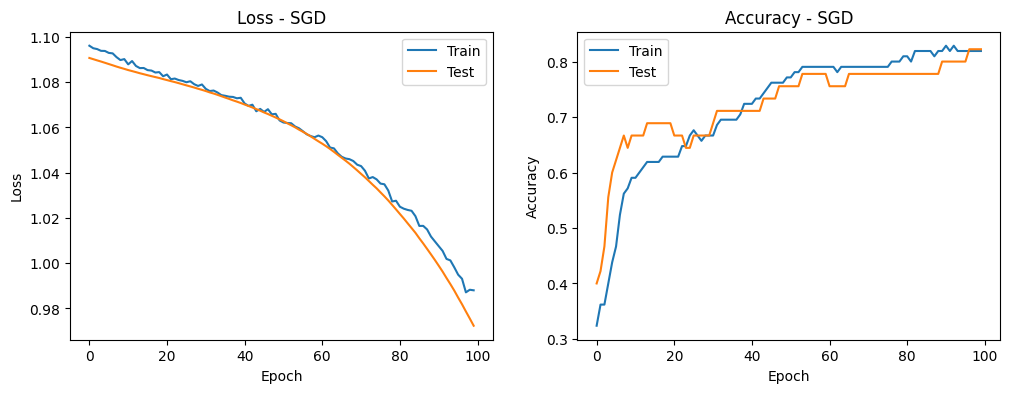

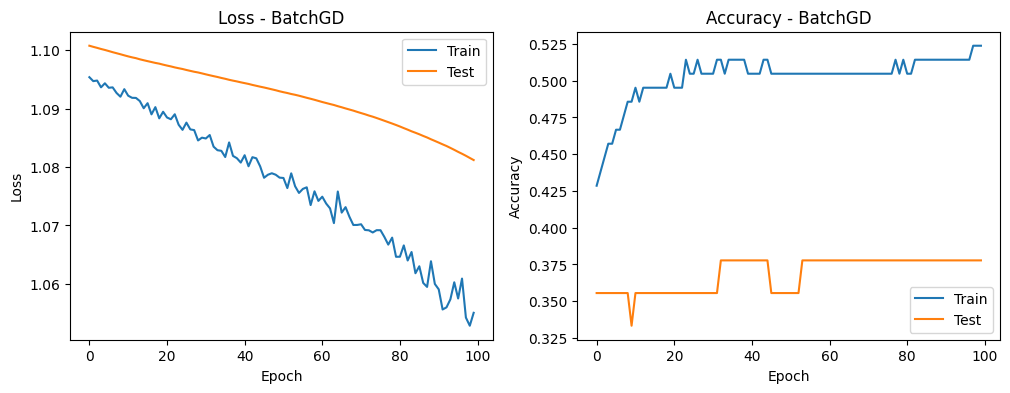

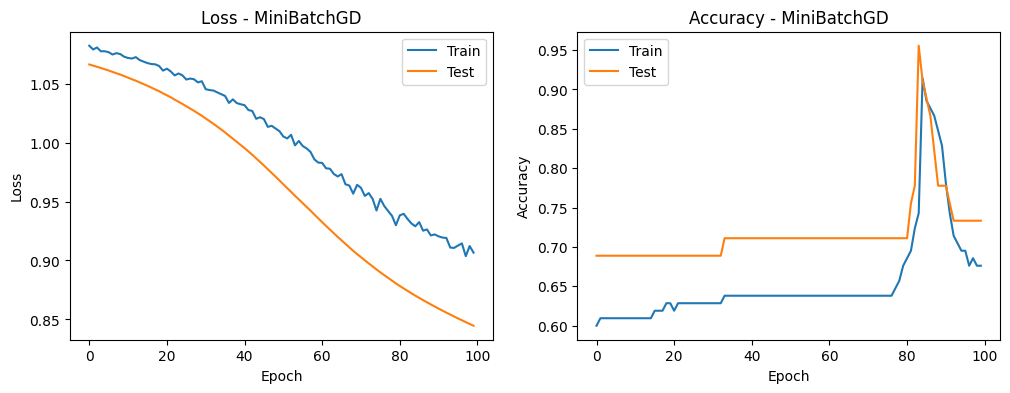

In [11]:
# Gráficos
for optimizer, result in results.items():
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(result['train_loss'], label='Train')
    plt.plot(result['test_loss'], label='Test')
    plt.title(f'Loss - {optimizer}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result['train_acc'], label='Train')
    plt.plot(result['test_acc'], label='Test')
    plt.title(f'Accuracy - {optimizer}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

### 🧪 Experimentación y Análisis

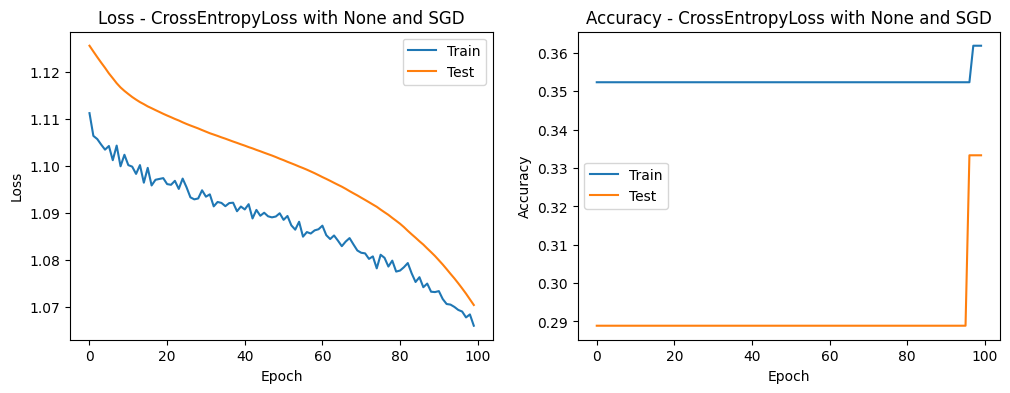

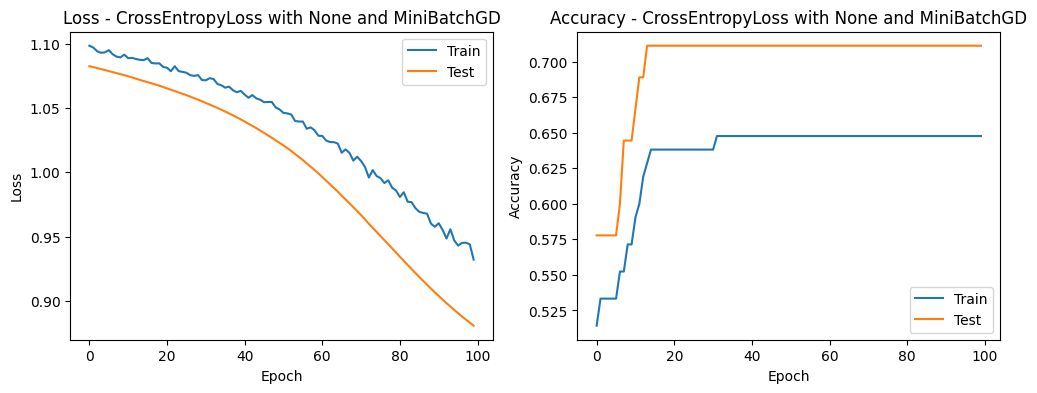

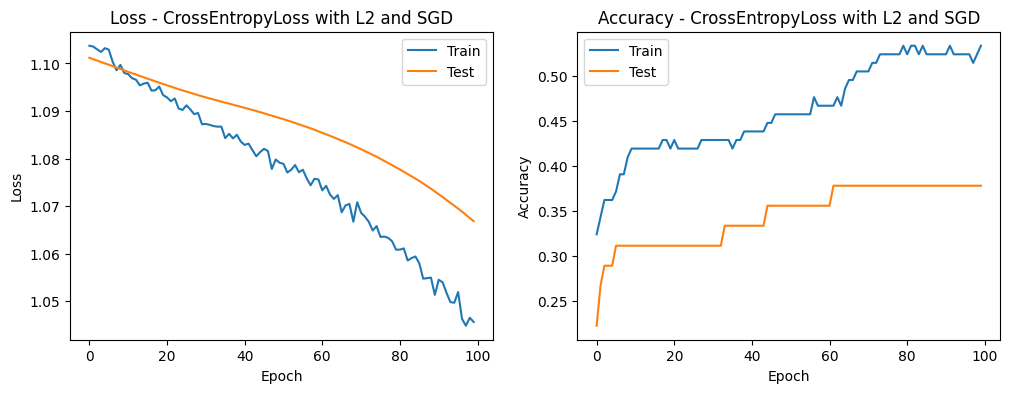

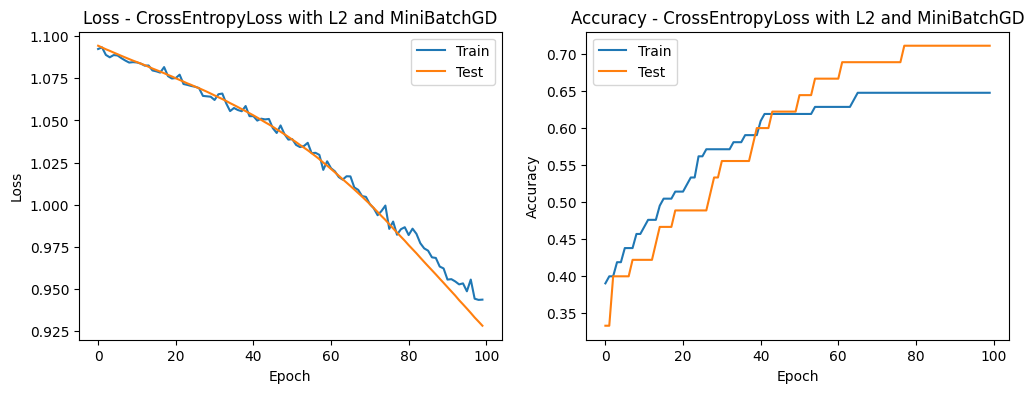

In [13]:
def experiment_combinations():
    # Definir combinaciones para entrenamiento.
    loss_functions = [nn.CrossEntropyLoss()]
    regularizations = ['None', 'L2']
    optimizers = ['SGD', 'MiniBatchGD']

    combinations = []
    for loss in loss_functions:
        for reg in regularizations:
            for opt in optimizers:
                combinations.append((loss, reg, opt))

    results = []

    for loss_fn, reg, optimizer_name in combinations:
        model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size).to(device)

        if optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01)
        elif optimizer_name == 'MiniBatchGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01)

        if reg == 'L2':
            optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        start_time = time.time()

        for epoch in range(100):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_losses.append(running_loss / len(train_loader))
            train_accuracies.append(correct / total)

            # Validación
            model.eval()
            test_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    test_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            test_losses.append(test_loss / len(test_loader))
            test_accuracies.append(correct / total)

        end_time = time.time()
        training_time = end_time - start_time

        results.append({
            'loss_fn': loss_fn.__class__.__name__,
            'regularization': reg,
            'optimizer': optimizer_name,
            'train_loss': train_losses,
            'test_loss': test_losses,
            'train_acc': train_accuracies,
            'test_acc': test_accuracies,
            'time': training_time
        })

    # Graficar los resultados obtenidos.
    for result in results:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(result['train_loss'], label='Train')
        plt.plot(result['test_loss'], label='Test')
        plt.title(f"Loss - {result['loss_fn']} with {result['regularization']} and {result['optimizer']}")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(result['train_acc'], label='Train')
        plt.plot(result['test_acc'], label='Test')
        plt.title(f"Accuracy - {result['loss_fn']} with {result['regularization']} and {result['optimizer']}")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()
        print("\n")

experiment_combinations()

### 🗣️ Discusión

Task 7

## 📚 Ejercicio 2 - Attention Is All You Need

1. **¿Cuál es la principal innovación de la arquitectura Transformer?**

La arquitectura transformer posee como principal innovación ser el primer modelo que maneja secuencias de datos basado en su totalidad en Attention, con tal de poder procesar los elementos de la secuencia simultáneamente, gracias a la Multi-Headed Self-Attention.

2. **¿Cómo funciona el mecanismo de atención del scaled dot-product?**

Consiste en queries, keys y values de distintas dimensiones. Se realiza un producto punto entre los queries y keys, posteriormente se divide este producto punto entre los valores de la dimensión de la key en cuestión. Al obtener los resultados, se aplica sobre ellos la función softmax para obtener los pesos de los values.

3. **¿Por qué se utiliza la atención de múltiples cabezales en Transformer?**
4. **¿Cómo se incorporan los positional encodings en el modelo Transformer?**
5. **¿Cuáles son algunas aplicaciones de la arquitectura Transformer más allá de la machine translation?**